In [ ]:
! pip install -q -U langchain_community langgraph langchain_groq langchain langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
os.environ["FIREWORKS_API_KEY"] = userdata.get("FIREWORKS_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["SERPAPI_API_KEY"] = userdata.get("SERPAPI_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"] = "MultiAgent"


In [ ]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonREPL()

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="llama3-70b-8192")


In [ ]:
llm.invoke("what is correlated subquery")

AIMessage(content='A correlated subquery, also known as a synchronized subquery, is a type of subquery that refers to the outer query\'s table(s) in its WHERE or HAVING clause. In other words, a correlated subquery is a subquery that uses values from the outer query to filter its own results.\n\nHere\'s a general syntax:\n```sql\nSELECT column1, column2, ...\nFROM table1\nWHERE condition = (subquery that references table1);\n```\nThe subquery is "correlated" because it references the outer query\'s table(s) using a table alias or the original table name. This allows the subquery to access columns from the outer query\'s table(s) and use them to filter its own results.\n\nHere\'s an example:\n```sql\nSELECT order_id, customer_id\nFROM orders\nWHERE total_amount > (SELECT AVG(total_amount)\n                     FROM orders o2\n                     WHERE o2.customer_id = orders.customer_id);\n```\nIn this example, the subquery calculates the average total amount for each customer, and the

In [ ]:
from langchain_core.tools import tool

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [ ]:
from langchain.agents import AgentExecutor,create_openai_functions_agent
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage

def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [ ]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict



# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [ ]:
import functools
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = llm

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [ ]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = llm

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [ ]:
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"


In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph, START

tool_node = ToolNode(tools=tools)

NameError: name 'tools' is not defined

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

NameError: name 'StateGraph' is not defined

In [ ]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


class AgentState(TypedDict):

    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

In [ ]:
for member in members:

    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

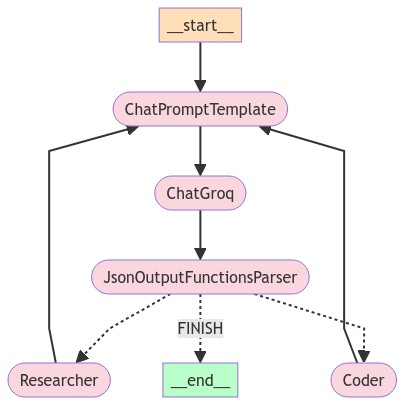

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


{'Coder': {'messages': [HumanMessage(content='The output of the tool is the final answer, so I will respond directly with the final answer. The final answer is: Hello, World!', name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='The final answer is: Hello, World!', name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='The final answer is: Hello, World!', name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='The final answer is: Hello, World!', name='Coder')]}}
----
{'supervisor': {'next': 'Researcher'}}
----


AssertionError: 

In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Tell me the best place in jaipur")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="According to the search results, some of the best places to visit in Jaipur are:\n\n1. City Palace, Jaipur - a magnificent palace that showcases the rich heritage of Rajputana culture.\n2. Amer Fort - a popular tourist attraction that offers a unique blend of Hindu and Muslim architectural styles.\n3. Hawa Mahal - a stunning palace with a honeycombed facade that resembles the crown of the Hindu god Krishna.\n4. Nahargarh Fort - a beautiful fort that offers breathtaking views of the city and is a great spot for trekking and hiking.\n5. Elefantastic - a unique conservation project that provides a sanctuary for elephants and offers elephant rides and other activities.\n\nThese are just a few of the many amazing places to visit in Jaipur. The city is steeped in history and culture, and there's always something new to explore!", name='Researcher')]}}
----
{'supervisor': {'next': 'Researcher'}}
---

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01hvp2r17re9tv5drfprrp0ryd` on tokens per minute (TPM): Limit 6000, Used 6544, Requested 6150. Please try again in 1m6.944s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}